In [16]:
from custom_functions import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

In [17]:
def f1(x_arr, b, g):
    #x_arr is an array where x_arr[0] = x and x_arr[1] = z

    dxdt = x_arr[0] - (x_arr[0]**2)*np.exp(-b*x_arr[0]*x_arr[1])
    dzdt = x_arr[1] - (x_arr[1]**2)*np.exp(-g*x_arr[0])

    return np.array([dxdt, dzdt])


def df(x):
    h = 1e-06
    J = MyJacobian(function_being_used, x, h)
    if J.ndim > 2:
        J = J.squeeze(axis=2)
    return J

def function_for_IVP(t, x):
    b = 1
    g = -1
    return f1(x, b, g)

## Eqlib points for g = -1, b = 1 is (1.4108, 0.2439)

## Now to track the euqlib, 
need to set up a RHS

## userf1 is without extra dims

In [18]:


def userdf(x):
    h = 1e-06
    J = MyJacobian(userf, x, h)
    if J.ndim > 2:
        J = J.squeeze(axis=2)
    return J

In [19]:
def userf1(t, x_arr, p):
    '''2D ODE system for the AMOC
    Input
    t  : float
        time value
    x  : array (2, N)
        state space values
    p  : array (2,)
        parameter values
    
    
    Returns
    xout: array, shape (2, N)
           Array containing derivative at x
           2nd dimension denotes derivatives for different points
    '''
    
    if x_arr.ndim == 1:
        x_arr = np.expand_dims(x_arr, axis=1)
    
    n = x_arr.shape
    xout = np.empty(n)
    xout[:] = np.nan 

    b = p[0,]
    g = p[1,]
    
    
    xout[0,:] = x_arr[0, :] - (x_arr[0, :]**2)*np.exp(-b*x_arr[0, :]*x_arr[1, :])
    xout[1,:] = x_arr[1, :] - (x_arr[1, :]**2)*np.exp(-g*x_arr[0, :])
    return xout

# Find Eq with b = 1, g = -1

In [76]:
#Param p defined for all functions  below
b = 0.6
g = -2
p = np.array([b, g])

[[1.5        1.49999962 1.49999583 ... 1.07778551 1.07778551 1.07778551]
 [0.2        0.1999994  0.19999336 ... 0.11583703 0.11583703 0.11583703]]


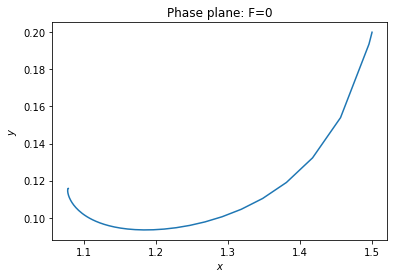

In [77]:
def func_for_scipy_ivp(t, x_arr, b, g):
    #g is included in x_arr
    #x_arr is an array where x_arr[0] = x and x_arr[1] = z, x_arr[2] = g
    #b = p[0]
    #g = p[1]

    dxdt = x_arr[0] - (x_arr[0]**2)*np.exp(-b*x_arr[0]*x_arr[1])
    dzdt = x_arr[1] - (x_arr[1]**2)*np.exp(-g*x_arr[0])

    return np.array([dxdt, dzdt])

#Using scipy solver test
tspan = [0,100]
x0 = np.array([1.5,0.2])
sol = solve_ivp(func_for_scipy_ivp,tspan, x0, args= (p), first_step = 1e-6, max_step = 1e-1)

#t = np.linspace(0, 100, 1000)
#points = sol.sol(t)


print(sol.y)
plt.plot(sol.y[0], sol.y[1])
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Phase plane: F=0")

plt.show()

[1.07778551 0.11583703]


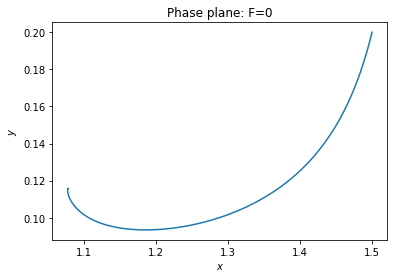

In [78]:
#parameter p


#define variable to go into MyIVP
x0 = np.array([1.5,0.2])
tspan = [0,100]
h = 0.01

#call MyIVP
[X,t,xeq1] = MyIVP(lambda t,x:userf1(t,x,p),x0,tspan,h)
X = np.squeeze(X)
xeq1 = np.squeeze(xeq1)
print(xeq1)

#Plot
plt.plot(X[0,:],X[1,:])
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Phase plane: F=0")

plt.show()

### Jacobian and Eigenvalues

In [44]:

J = MyJacobian(lambda x:userf1(0,x,p),xeq1,h)
eig_val_xeq1 = linalg.eig(J[:,:,0])[0]

print(eig_val_xeq1)

[-0.78630012+0.53102259j -0.78630012-0.53102259j]


# Now Track the Equilibria

In [86]:


# Define RHS for tracking equilibria
RHS = lambda y: userf1(0,y[0:2,:],np.array([b, y[2,:]]))

h=1e-6
df= lambda y: np.squeeze(MyJacobian(RHS,y,h),axis=2)

# Define MyTrackCurve initial points, MAKE GUESS OF Y TANGENT
y0 = np.append(xeq1,np.array([g]),axis=0)
print(y0)
ytan0 = np.expand_dims(np.array([0.,0.,1.]),axis=1) # guess in the direction of increasing F

# Solve for the true initial tangent
df0 = df(y0)
zeros0 = np.zeros((2,))
zeros1 = np.append(zeros0,np.array([1.]),axis=0)
f0 = np.concatenate((df0,np.transpose(ytan0)),axis=0)
z = np.linalg.lstsq(f0,zeros1,rcond=None)[0]
mult = np.sign(np.matmul(np.transpose(z),ytan0))
ytan = np.divide(z,linalg.norm(z))*mult

print(ytan)

ylist1 = MyTrackCurve(RHS,df,y0,ytan,nmax=2000,stepsize=0.01)


#NOW OTHER DIRECTION
# guess in direction for decreasing F
ytan0 = np.expand_dims(np.array([0.,0.,-1.]),axis=1)

# Solve for the true initial tangent
f0 = np.concatenate((df0,np.transpose(ytan0)),axis=0)
z = np.linalg.lstsq(f0,zeros1,rcond=None)[0]
mult = np.sign(np.matmul(np.transpose(z),ytan0))
ytan = np.divide(z,linalg.norm(z))*mult

ylist2 = MyTrackCurve(RHS,df,y0,ytan,nmax=1000,stepsize=0.01)

###Concatenate
#ylist = np.concatenate((np.flip(ylist2,1),ylist1),axis=1)
ylist = ylist1.copy()

[ 1.07778551  0.11583703 -2.        ]
[0.07938322 0.10536527 0.99126004]


C:\Users\aaron\AppData\Local\Temp\ipykernel_42632\1876674364.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  RHS = lambda y: userf1(0,y[0:2,:],np.array([b, y[2,:]]))


[ 1.07778551  0.11583703 -2.        ]


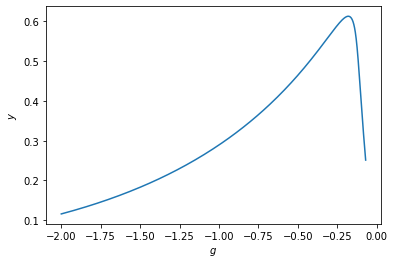

In [87]:
#ylist = np.concatenate((np.flip(ylist2,1),ylist1),axis=1)
#ylist = ylist1.copy
print(ylist[:,0])
plt.plot(ylist[2,:],ylist[1,:])
plt.xlabel("$g$")
plt.ylabel("$y$")

plt.show()

## Plotting

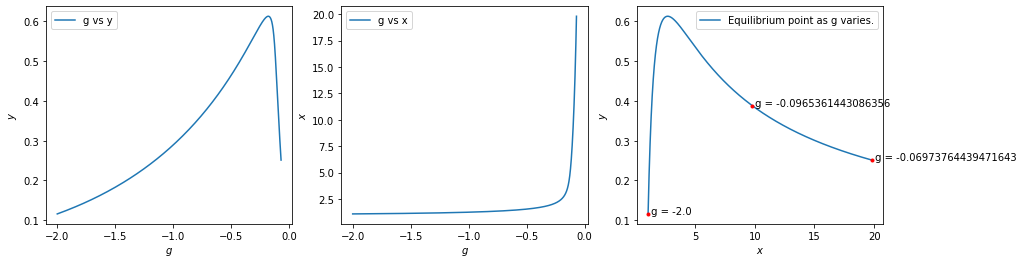

In [88]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

ax1 = axs[0]
ax1.plot(ylist[2,:],ylist[1,:], label = 'g vs y')
ax1.set_xlabel("$g$")
ax1.set_ylabel("$y$")
ax1.legend()
ax1.set_title("")

ax2 = axs[1]
ax2.plot(ylist[2,:], ylist[0,:], label = 'g vs x')
ax2.set_xlabel("$g$")
ax2.set_ylabel("$x$")
ax2.legend()
ax2.set_title("")

ax3 = axs[2]
length = ylist.shape[1] # The number of points in ylist
ax3.plot(ylist[0,:], ylist[1,:], label = 'Equilibrium point as g varies.')
label = ' g = ' + str(ylist[2,0])
ax3.plot(ylist[0,0], ylist[1,0], '.', color = 'r')
ax3.text(ylist[0,0], ylist[1,0],label)

label = ' g = ' + str(ylist[2,int(length/2)])
ax3.plot(ylist[0,int(length/2)], ylist[1,int(length/2)], '.', color = 'r' )
ax3.text(ylist[0,int(length/2)], ylist[1,int(length/2)],label)

label = ' g = ' + str(ylist[2,length-1])
ax3.plot(ylist[0,int(length-1)], ylist[1,int(length-1)], '.', color = 'r' )
ax3.text(ylist[0,int(length-1)], ylist[1,int(length-1)],label)

ax3.set_xlabel("$x$")
ax3.set_ylabel("$y$")
ax3.legend()
ax3.set_title("")

#ax4 = axs[1, 1]

plt.show()

### Find stability at each point

In [99]:
#Finding the eigen values (eig_val), and stability (stab) at at value of g
stab = np.empty((ylist.shape[1],1))*np.nan
#note that the number of eigen values at each point of g will be ylist's (=[x,z,g])  width-1
eig_val = np.empty((ylist.shape[1],ylist.shape[0]-1),dtype=np.csingle)*np.nan

print('should be same',ylist[0:2,0], xeq1)

#J = MyJacobian(lambda x:userf1(0,x,p_i),ylist[0:2,i],h)
#eig_val[i,:] = linalg.eig(J[:,:,0])[0]

for i in np.arange(0,ylist.shape[1]):
    p_i =np.array([b, ylist[2,i]])
    J = MyJacobian(lambda x:userf1(0,x,p_i),ylist[0:2,i],h)
    eig_val[i,:] = linalg.eig(J[:,:,0])[0]
    max_eig = max(np.real(eig_val[i,:]))
    stab[i] = max_eig > 0
    if (i>0 and stab[i] != stab[i-1] and stab[i-1] != 10):
        #print(max_eig)
        stab[i] = 10


#print(eig_val)

should be same [1.07778551 0.11583703] [1.07778551 0.11583703]


In [97]:
for i in range(ylist.shape[1]):
    print(ylist[:,i])

[ 1.07778551  0.11583703 -2.        ]
[ 1.07858372  0.11689528 -1.99008824]
[ 1.07939076  0.11796279 -1.98017819]
[ 1.08020674  0.11903963 -1.97026988]
[ 1.08103178  0.12012588 -1.96036334]
[ 1.081866    0.12122162 -1.95045862]
[ 1.08270952  0.12232692 -1.94055575]
[ 1.08356245  0.12344186 -1.93065477]
[ 1.08442493  0.12456652 -1.92075571]
[ 1.08529708  0.12570099 -1.91085862]
[ 1.08617902  0.12684534 -1.90096354]
[ 1.08707089  0.12799966 -1.8910705 ]
[ 1.08797282  0.12916402 -1.88117955]
[ 1.08888494  0.13033851 -1.87129074]
[ 1.0898074   0.13152321 -1.8614041 ]
[ 1.09074032  0.1327182  -1.85151968]
[ 1.09168385  0.13392358 -1.84163753]
[ 1.09263814  0.13513941 -1.8317577 ]
[ 1.09360334  0.1363658  -1.82188023]
[ 1.09457958  0.13760282 -1.81200517]
[ 1.09556702  0.13885056 -1.80213257]
[ 1.09656582  0.14010911 -1.79226249]
[ 1.09757614  0.14137856 -1.78239498]
[ 1.09859813  0.14265898 -1.77253008]
[ 1.09963195  0.14395048 -1.76266787]
[ 1.10067777  0.14525315 -1.75280839]
[ 1.10173576

In [100]:
print('element 1178', eig_val[1178])

for i in eig_val:
    print(i)

element 1178 [0.224935+1.0270208j 0.224935-1.0270208j]
[-0.96254575+0.40008464j -0.96254575-0.40008464j]
[-0.9621756+0.40118292j -0.9621756-0.40118292j]
[-0.9618016+0.40228134j -0.9618016-0.40228134j]
[-0.96142375+0.4033799j -0.96142375-0.4033799j]
[-0.96104205+0.40447855j -0.96104205-0.40447855j]
[-0.96065634+0.4055773j -0.96065634-0.4055773j]
[-0.96026665+0.40667608j -0.96026665-0.40667608j]
[-0.9598729+0.4077749j -0.9598729-0.4077749j]
[-0.9594751+0.40887365j -0.9594751-0.40887365j]
[-0.9590731+0.40997237j -0.9590731-0.40997237j]
[-0.958667+0.41107097j -0.958667-0.41107097j]
[-0.9582566+0.41216946j -0.9582566-0.41216946j]
[-0.95784193+0.41326776j -0.95784193-0.41326776j]
[-0.9574229+0.4143659j -0.9574229-0.4143659j]
[-0.95699954+0.41546375j -0.95699954-0.41546375j]
[-0.9565717+0.41656137j -0.9565717-0.41656137j]
[-0.9561393+0.41765863j -0.9561393-0.41765863j]
[-0.9557025+0.41875556j -0.9557025-0.41875556j]
[-0.955261+0.41985208j -0.955261-0.41985208j]
[-0.95481485+0.42094818j -0.954

### Plot stabilities

7.398061989381927 0.45084286385973865 -0.1076817710499291


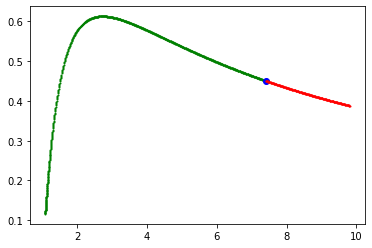

In [85]:
for i in np.arange(0,ylist.shape[1]):
    if stab[i] == False:
        plt.plot(ylist[0,i],ylist[1,i],'g.',markersize=2,label = 'stable eq')
    elif stab[i] == True:
        plt.plot(ylist[0,i],ylist[1,i],'r.',markersize=2,label = 'unstable eq')
    elif stab[i] == 10:
        plt.plot(ylist[0,i],ylist[1,i],marker='o',color='b',markersize=6,label='SN')
        print(ylist[0,i],ylist[1,i], ylist[2,i])
        #print(eig_val[i])
        
    else:
        print('Error - undefined stability type')


# 2 Parameter Track (in b and g)
The change in stability found above was likely a hopf Bif

In [28]:
#Define functions
def df_2param(y):
    J = MyJacobian(lambda x:userf1(0,x,np.array([y[3],y[2]])),y[0:2],h)
    J = np.squeeze(J,axis=2)
    return J

######### Fold Bif ############

RHS_fold = lambda y: np.append(userf1(0,y[0:2,:],np.array([y[3,:],y[2,:]])),
                               np.expand_dims(np.array([linalg.det(df_2param(y))]),axis=1),axis=0)

df_fold= lambda y: np.squeeze(MyJacobian(RHS_fold,y,h),axis=2)

######### Hopf Bif ############

RHS_hopf = lambda y: np.append(userf1(0,y[0:2,:],np.array([y[3,:],y[2,:]])),
                               np.expand_dims(np.array([np.trace(df_2param(y))]),axis=1),axis=0)

df_hopf= lambda y: np.squeeze(MyJacobian(RHS_hopf,y,h),axis=2)

### Track Curve

In [29]:
#RHS_used and df_used is either RHS_fold or RHS_hopf
RHS_used = RHS_hopf
df_used = df_hopf


# Define MyTrackCurve initial points
b = 1
f_inds = np.where(stab == 10)[0]
y0 = np.array([ylist[0,f_inds[0]], ylist[1,f_inds[0]], ylist[2,f_inds[0]],b])
print('y0', y0)

p_i =np.array([b, ylist[2,f_inds[0]]])
J = MyJacobian(lambda x:userf1(0,x,p_i),ylist[0:2,f_inds[0]],h)
eig_val = linalg.eig(J[:,:,0])[0]


ytan0 = np.expand_dims(np.array([0,0,1,1]),axis=1) # guess i the direction of increasing params

# Solve for the true initial tangent
df0 = np.squeeze(df_used(y0))
zeros0 = np.zeros((3,))
zeros1 = np.append(zeros0,np.array([1.]),axis=0)
f0 = np.concatenate((df0,np.transpose(ytan0)),axis=0)
z = np.linalg.lstsq(f0,zeros1,rcond=None)[0]
mult = np.sign(np.matmul(np.transpose(z),ytan0))
ytan = np.divide(z,linalg.norm(z))*mult
print('ytan', ytan)

yused1 = MyTrackCurve(RHS_used,df_used,y0,ytan,stepsize=0.1,nmax=200)

# guess in direction for decreasing params
ytan0 = np.expand_dims(np.array([0,0,-1,-1]),axis=1)

# Solve for the true initial tangent
f0 = np.concatenate((df0,np.transpose(ytan0)),axis=0)
z = np.linalg.lstsq(f0,zeros1,rcond=None)[0]
mult = np.sign(np.matmul(np.transpose(z),ytan0))
ytan = np.divide(z,linalg.norm(z))*mult

yused2 = MyTrackCurve(RHS_used,df_used,y0,ytan,stepsize=0.1,nmax=200)

y0 [ 7.39647752  0.27053471 -0.17675372  1.        ]
ytan [ 0.00287664 -0.2590004  -0.12936649  0.95717022]


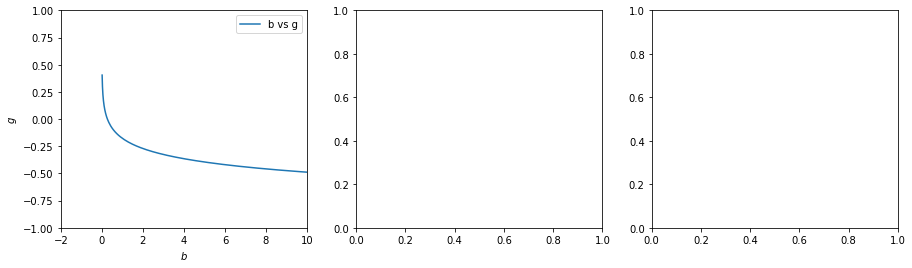

In [30]:
yused = np.concatenate((np.flip(yused2,1),yused1),axis=1)
#print(yused)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

ax1 = axs[0]
ax1.plot(yused[3,:],yused[2,:], label = 'b vs g')
#ax1.plot(yused1[:,2],yused1[:,3], label = 'b vs g')
ax1.set_xlabel("$b$")
ax1.set_ylabel("$g$")
ax1.set_xlim(-2,10)
ax1.set_ylim(-1,1)
ax1.legend()
ax1.set_title("")



#plt.axis([0.7,1.3,0,100])

plt.show()

### Storing the var

In [35]:
TwoD_Hopf_Track = yused
%store TwoD_Hopf_Track

Stored 'TwoD_Hopf_Track' (ndarray)


Stored variables and their in-db values:
